<h1 style="color: #00BFFF;">00 | Import Libraries</h1>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Basic Libraries
import os
import json
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Computer Vision
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

<h1 style="color: #00BFFF;">02 | Data Preprocessing</h1>

In [ ]:
# Data Path
dataset_path= '/content/drive/MyDrive/IRONHACK/W8/computer_vision_project/data'

In [ ]:
# Path for every folder
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')
validation_dir = os.path.join(dataset_path, 'val')

<h2 style="color: #008080;">Data Cleaning</h2>

Cleaning data images from the dataset. Checking for **corrupted images** and deleting them.

In [ ]:
def remove_invalid_images(folder_path):
    removed = 0
    for root, _, files in os.walk(folder_path):
        for fname in files:
            fpath = os.path.join(root, fname)
            try:
                img_read = tf.io.read_file(fpath)
                img_2 = tf.image.decode_image(img_read)

            except tf.errors.InvalidArgumentError:
                print(f"Removing: {fpath}")
                os.remove(fpath)
                removed += 1
    print(f"Removed {removed} corrupted/invalid images from {folder_path}")

In [ ]:
# Check all your datasets
remove_invalid_images(os.path.join(train_dir, "fractured"))
remove_invalid_images(os.path.join(train_dir, "not fractured"))
remove_invalid_images(os.path.join(test_dir, "fractured"))
remove_invalid_images(os.path.join(test_dir, "not fractured"))
remove_invalid_images(os.path.join(validation_dir, "fractured"))
remove_invalid_images(os.path.join(validation_dir, "not fractured"))

<h2 style="color: #FF6347;">Preprocessing the Dataset</h2>

In [ ]:
# Define the image size and batch size
img_size = (224, 224)  # resize images
batch_size = 64

In [ ]:
# Load the training, validation, and test datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)

Found 9239 files belonging to 2 classes.
Found 823 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


<h2 style="color: #008080;">Data Augmentation, Normalization & Prefetching</h2>

<h4 style="color: #FF6347;">Prefetching</h4>

In [ ]:
# Determine the optimal buffer size for the system
tf.data.AUTOTUNE

-1

In [ ]:
autotune = tf.data.AUTOTUNE

In [ ]:
# Optimize dataset performance with prefetching
train_dataset = train_dataset.prefetch(buffer_size=autotune)
validation_dataset = validation_dataset.prefetch(buffer_size=autotune)
test_dataset = test_dataset.prefetch(buffer_size=autotune)

<h4 style="color: #FF6347;">Image normalization</h4>

In [ ]:
# Define a function to normalize images
def normalize_image(image):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize pixel values to [0, 1]
    return image

In [ ]:
# Apply normalization to each image in the dataset
train_dataset = train_dataset.map(lambda image, label: (normalize_image(image), label))
validation_dataset = validation_dataset.map(lambda image, label: (normalize_image(image), label))
test_dataset = test_dataset.map(lambda image, label: (normalize_image(image), label))

<h4 style="color: #FF6347;">Augmentation</h4>

In [ ]:
# Data Augmentation
horizontal_flips = tf.keras.layers.RandomFlip('horizontal')
radians = tf.keras.layers.RandomRotation(0.08)

In [ ]:
data_augmentation = tf.keras.Sequential([
    horizontal_flips,
    radians
])

In [ ]:
def augmented_images(example_dataset, data_augmentation):
  plt.figure(figsize=(10, 10))
  for images, _ in example_dataset.take(1):
      sample_image = images[0]
      for i in range(9):
          ax = plt.subplot(3, 3, i + 1)
          augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))
          plt.imshow(augmented_image[0].numpy().astype("uint8"))
          plt.axis('off')
          plt.title(f"Augmented Image {i+1}", fontsize=12)
  plt.suptitle("Sample Augmented Images", fontsize=16)
  plt.tight_layout()
  plt.subplots_adjust(top=0.9)
  plt.show()

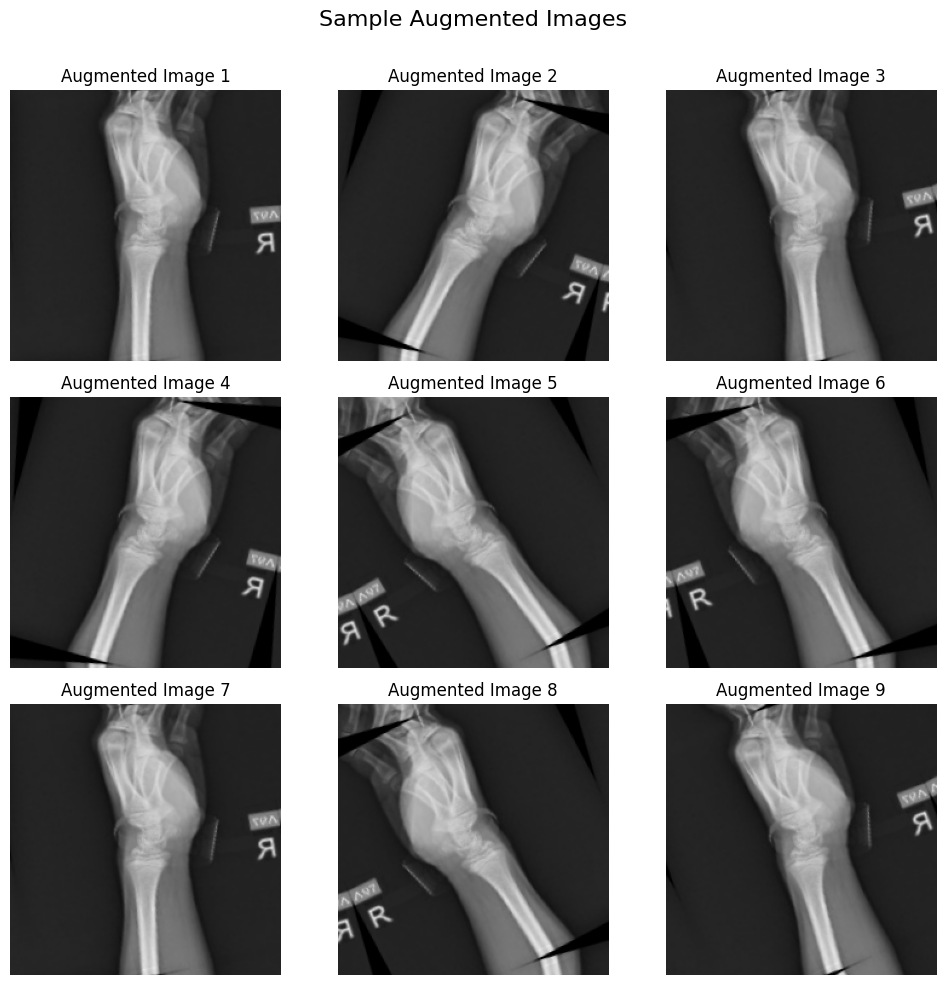

In [ ]:
# Visualize augmented images
augmented_images(train_dataset, data_augmentation)

In [ ]:
# Save tensor dataset
test_dataset.save('/content/drive/MyDrive/IRONHACK/W8/computer_vision_project/data/tensor_dataset/test_dataset')

<h1 style="color: #00BFFF;">03 | Baseline Model: ResNet-50</h1>

In [ ]:
# 3 for RGB
img_shape = img_size + (3,)

In [ ]:
img_shape

(224, 224, 3)

In [ ]:
# Load ResNet50 model without the top (no classification layer)
pretrained_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='avg'  # Global average pooling (reduces the feature map size)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Check the number of layers of our ResNet-50 model
len(pretrained_model.layers)

176

In [ ]:
pretrained_model.trainable = False  # Now the ResNet50 layers will be trainable

In [ ]:
resnet_model = tf.keras.Sequential([
    data_augmentation,
    pretrained_model, # Add the pre-trained ResNet50 model
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification output
])

In [ ]:
resnet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (1, 224, 224, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (1, 2048)                   │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (1, 2048)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 512)                    │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 1)                      │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

<h2 style="color: #FF6347;">Training the Model</h2>

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=batch_size, # Learning rate will decrease every batch
    decay_rate=0.8 # rate of decrease means 90% of the learning rate is decreased
)

In [ ]:
# Compile the model structure for training
base_learning_rate = 0.1
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), # Adam deals with gradient descent
              loss=tf.keras.losses.BinaryCrossentropy(), # measures the difference between two probability distributions
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]) # calculates how often predictions match binary labels

In [ ]:
# Define callbacks
drive_model_path = '/content/drive/MyDrive/IRONHACK/W8/computer_vision_project/models/best_model_resnet.keras'

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=drive_model_path, monitor='val_loss', save_best_only=True)

In [ ]:
# Set the initial epochs
initial_epochs = 40

In [ ]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

<h3 style="color: #FF8C00;">Training & Saving (Best Model + Metrics)</h3>

In [ ]:
import json

# Train the model with callbacks
history = resnet_model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping, model_checkpoint], # Callbacks are used to customize the training process
    verbose=1  # Verbosity level: 1 = progress bar, 2 = one line per epoch
)

# Define the path to save the file in Google Drive
drive_path = '/content/drive/MyDrive/IRONHACK/W8/computer_vision_project/scripts/training_history_resnet.json'

# Save the training history to Google Drive
with open(drive_path, 'w') as file:
    json.dump(history.history, file)

Epoch 1/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 458s 3s/step - accuracy: 0.7992 - loss: 0.4954 - val_accuracy: 0.9417 - val_loss: 0.1869
Epoch 2/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - accuracy: 0.9730 - loss: 0.1071 - val_accuracy: 0.9550 - val_loss: 0.1421
Epoch 3/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.9860 - loss: 0.0636 - val_accuracy: 0.9648 - val_loss: 0.1027
Epoch 4/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - accuracy: 0.9915 - loss: 0.0455 - val_accuracy: 0.9635 - val_loss: 0.1017
Epoch 5/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 16s 107ms/step - accuracy: 0.9934 - loss: 0.0369 - val_accuracy: 0.9721 - val_loss: 0.0846
Epoch 6/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.9959 - loss: 0.0320 - val_accuracy: 0.9733 - val_loss: 0.0849
Epoch 7/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.9950 - loss: 0.0303 - val_accuracy: 0.9733 - val_loss: 0.0861
Epoch 8/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.9958 - loss: 0.0280

In [ ]:
# Load training history
with open(drive_path, 'r') as file:
    training_history = json.load(file)


In [ ]:
# Combine training and fine-tuning metrics
acc = training_history['accuracy']
val_acc = training_history['val_accuracy']

loss = training_history['loss']
val_loss = training_history['val_loss']

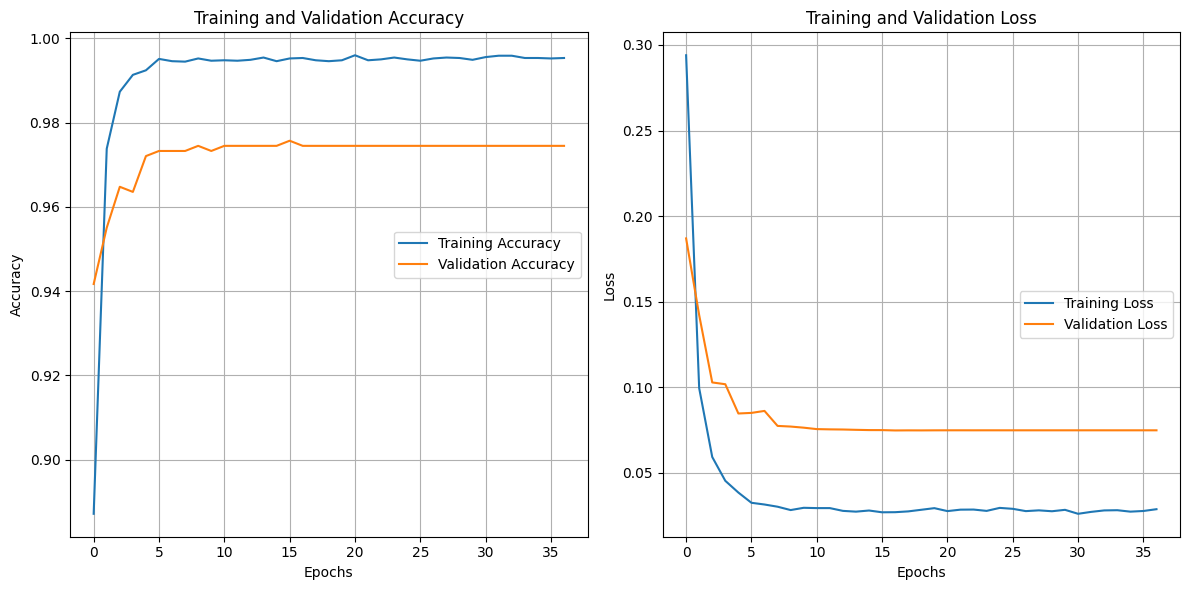

In [ ]:
# Plot accuracy and loss on the same grid
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy', color='#568ab9')
plt.plot(val_acc, label='Validation Accuracy', color='#f3e780')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss', color='#568ab9')
plt.plot(val_loss, label='Validation Loss', color='#f3e780')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

<h1 style="color: #00BFFF;">04 | Fine-Tuning the model</h1>

In [ ]:
# Unfreeze some layers for fine-tuning
pretrained_model.trainable = True

In [ ]:
# To get the layers from the resnet model
resnet_core = resnet_model.layers[1]  # This is pretrained_model

In [ ]:
len(resnet_core.layers)

176

In [ ]:
for layer in resnet_core.layers[:100]: # Freeze the first 100 layers
    layer.trainable = False

In [ ]:
fine_tune_learning_rate = base_learning_rate / 10 # 10 times smaller learning rate for fine-tuning

In [ ]:
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_learning_rate),  # Smaller learning rate
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]
)

In [ ]:
# Same callbacks
drive_model_path_fine_tune = '/content/drive/MyDrive/IRONHACK/W8/computer_vision_project/models/fine_tuned_model.keras'
fine_tune_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
fine_tune_model_checkpoint = ModelCheckpoint(filepath=drive_model_path_fine_tune, monitor='val_loss', save_best_only=True)

In [ ]:
# Define fine-tuning epochs
fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

In [ ]:
# Fine-tune the model
history_fine = resnet_model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Continue from where the initial training ended
    validation_data=validation_dataset,
    callbacks=[fine_tune_early_stopping, fine_tune_model_checkpoint],  # Add callbacks
    verbose=1
)

# Define the path to save the file in Google Drive
drive_path_fine_tune = '/content/drive/MyDrive/IRONHACK/W8/computer_vision_project/scripts/fine_tuning_history.json'

# Save the training history to Google Drive
with open(drive_path_fine_tune, 'w') as file:
    json.dump(history_fine.history, file)

Epoch 37/90
145/145 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.5909 - loss: 2.3800 - val_accuracy: 0.5091 - val_loss: 6.9746
Epoch 38/90
145/145 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.9363 - loss: 0.1793 - val_accuracy: 0.8578 - val_loss: 0.8818
Epoch 39/90
145/145 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.9815 - loss: 0.0560 - val_accuracy: 0.9465 - val_loss: 0.1402
Epoch 40/90
145/145 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.9874 - loss: 0.0355 - val_accuracy: 0.9392 - val_loss: 0.2690
Epoch 41/90
145/145 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.9898 - loss: 0.0293 - val_accuracy: 0.9648 - val_loss: 0.0908
Epoch 42/90
145/145 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.9954 - loss: 0.0134 - val_accuracy: 0.9648 - val_loss: 0.0874
Epoch 43/90
145/145 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - accuracy: 0.9952 - loss: 0.0118 - val_accuracy: 0.9818 - val_loss: 0.0499
Epoch 44/90
145/145 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - accuracy: 0.9947 - 

In [ ]:
# Load fine-tuning history
with open('fine_tuning_history.json', 'r') as file:
    fine_tuning_history = json.load(file)

In [ ]:
# Combine training and fine-tuning metrics
acc_fine = training_history['accuracy'] + fine_tuning_history['accuracy']
val_acc_fine = training_history['val_accuracy'] + fine_tuning_history['val_accuracy']

loss_fine = training_history['loss'] + fine_tuning_history['loss']
val_loss_fine = training_history['val_loss'] + fine_tuning_history['val_loss']

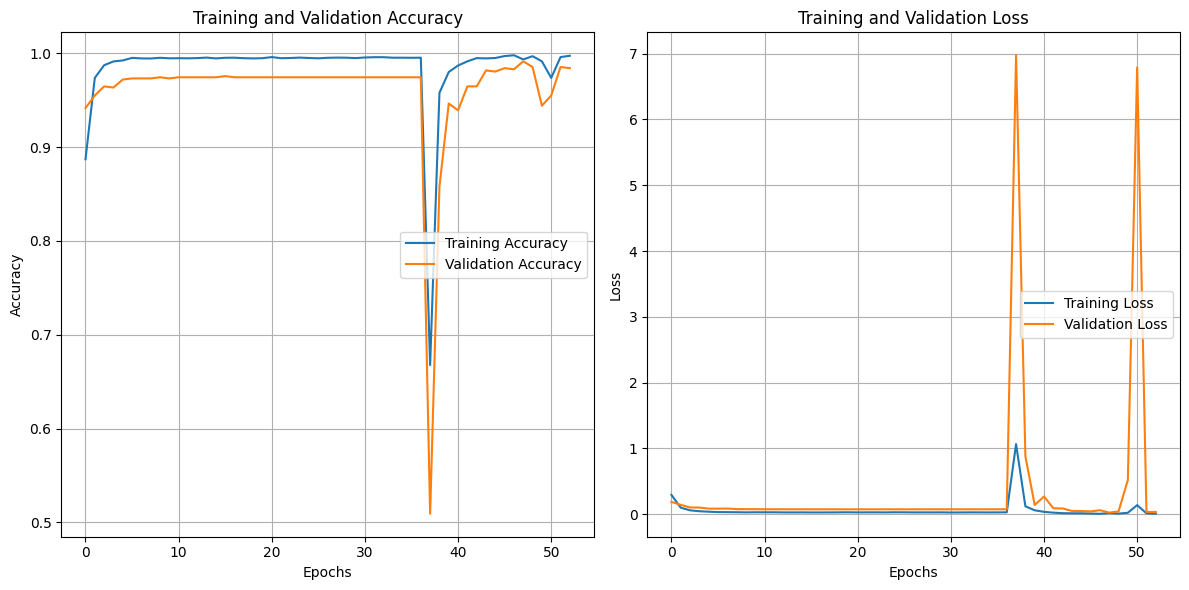

In [ ]:
# Plot accuracy and loss on the same grid
plt.figure(figsize=(15, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(acc_fine, label='Training Accuracy', color='#568ab9')
plt.plot(val_acc_fine, label='Validation Accuracy', color='#f3e780')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(loss_fine, label='Training Loss', color='#568ab9')
plt.plot(val_loss_fine, label='Validation Loss', color='#f3e780')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()